In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ks_2samp
%matplotlib inline

from sklearn import metrics
from sklearn import preprocessing, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.layers import Dense, Dropout, Input, LSTM, Activation
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Read Datasets 
research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')

# Drop unnecessary columns
research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [3]:
# Set Date column as index and drop other columns that won't be used by the model
research_data = research_data.set_index('Date')
research_data.index = pd.to_datetime(research_data.index)
research_data = research_data.sort_index()
research_data = research_data.drop(['Symbol','Popularity_Normalized','Volume BTC','Volume USD'], 1)
research_data.head()

,Open,High,Low,Close,Popularity
Date,,,,,
2014-05-18,453.83,453.83,445.56,445.56,2.0
2014-05-19,445.56,445.56,445.56,445.56,2.0
2014-05-20,445.56,498.84,445.56,493.43,2.0
2014-05-21,493.43,497.67,490.85,494.77,2.0
2014-05-22,494.77,530.00,494.77,530.00,2.0


In [4]:
# Get lenght of dataset
print(len(research_data))

1808


In [5]:
# Check for null values
research_data.isna().sum()

Open          0
High          0
Low           0
Close         0
Popularity    0
dtype: int64

In [6]:
# Define constants
TIME_STEPS = 10
TEST_SIZE = 0.1
EPOCHS = 400
BATCH_SIZE_NN = 4
GAN_TRAIN_BATCH_SIZE = 8
FEATURES = len(research_data.columns)

In [7]:
# Define train_test split function
def train_test_split(df, test_size):
    splitting_point = len(df) - int(test_size * len(df))
    train_data = df.iloc[:splitting_point]
    test_data = df.iloc[splitting_point:]
    return train_data, test_data

In [8]:
# Define plot function
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

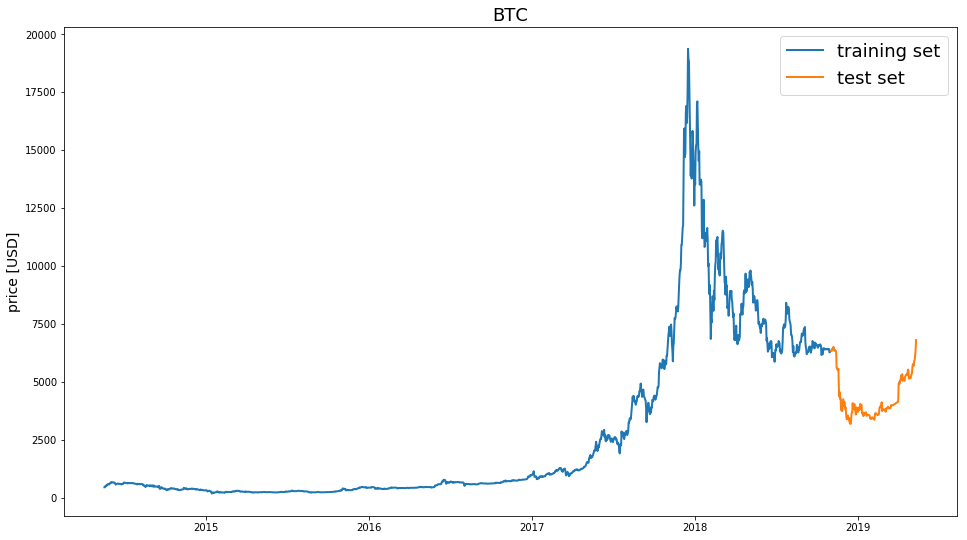

In [9]:
# Plot train and test sets
train, test = train_test_split(research_data, TEST_SIZE)
line_plot(train.Close, test.Close, 'training set', 'test set', 'BTC')

In [10]:
# Define function to normalize data with respect to first entry in the sequence. The first instance in the 
# sequence will always be zero (df / df.iloc[0] - 1) and all other instances will be relative to that first
# instance, representing the rate of change in the sequence
def get_rate_change_zero_base(df):
    return df / df.iloc[0] - 1

In [11]:
# Define function to convert dataframe into numpy array of sequences
def build_sequence(df, window_size):
    sequence_data = []
    for idx in range(len(df) - window_size):
        temp_data = df[idx: (idx + window_size)].copy()
        temp_data = get_rate_change_zero_base(temp_data)
        sequence_data.append(temp_data.values)
    return np.array(sequence_data)

In [12]:
# Define function to get training and test sets for GAN
def get_data(df, window_size, test_size):
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract sequence from data
    X_train = build_sequence(train_data, window_size)
    X_test = build_sequence(test_data, window_size)
    
    # extract targets
    y_train = train_data.Close[window_size:].values / train_data.Close[:-window_size].values - 1
    y_test = test_data.Close[window_size:].values / test_data.Close[:-window_size].values - 1
    
    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
# Get the proper sets for GAN
train, test, X_train, X_test, y_train, y_test = get_data(research_data, TIME_STEPS, TEST_SIZE)

# Print set shapes
print('X_train shape: ' + str(X_train.shape))
print('y_train shape: ' + str(y_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1618, 10, 5)
y_train shape: (1618,)
X_test shape: (170, 10, 5)
y_test shape: (170,)


In [14]:
# Create Generator Model and get its summary
def create_generator():
    optimizer = RMSprop(lr=0.005, clipvalue=1.)
    
    generator = Sequential()
    generator.add(LSTM(16, batch_input_shape=(BATCH_SIZE_NN, TIME_STEPS, FEATURES), return_sequences=True))
    generator.add(LeakyReLU(0.05))
    generator.add(LSTM(32,return_sequences=True))
    generator.add(LeakyReLU(0.05))
    generator.add(Dropout(0.5))
    generator.add(LSTM(64,return_sequences=False))
    generator.add(Dense(FEATURES))
    generator.add(Activation('tanh'))
    
    generator.compile(loss='mean_absolute_error', optimizer=optimizer)

    return generator

generator = create_generator()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (4, 10, 16)               1408      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (4, 10, 16)               0         
_________________________________________________________________
lstm_2 (LSTM)                (4, 10, 32)               6272      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (4, 10, 32)               0         
_________________________________________________________________
dropout_1 (Dropout)          (4, 10, 32)               0         
_________________________________________________________________
lstm_3 (LSTM)                (4, 64)                   24832     
_________________________________________________________________
dense_1 (Dense)              (4, 5)                    325       
__________

In [15]:
# Create Discriminator Model and get its summary
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()

    discriminator.add(Dense(units=32, batch_input_shape=(GAN_TRAIN_BATCH_SIZE, TIME_STEPS, FEATURES)))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=64))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.01))
    discriminator.add(Dense(units=220,activation='linear'))
    discriminator.add(Activation('relu'))
    discriminator.add(Dense(1,activation='linear'))
    
    discriminator.compile(loss='mean_absolute_error', optimizer=optimizer)
    
    return discriminator

discriminator = create_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (8, 10, 32)               192       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (8, 10, 32)               0         
_________________________________________________________________
dense_3 (Dense)              (8, 10, 64)               2112      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (8, 10, 64)               0         
_________________________________________________________________
dense_4 (Dense)              (8, 10, 128)              8320      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (8, 10, 128)              0         
_________________________________________________________________
dense_5 (Dense)              (8, 10, 220)              28380     
__________

In [16]:
# Create GAN with Generator and Discriminator and get its summary
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8) 
    discriminator.trainable=False
    
    gan_input = Input(shape=(TIME_STEPS, FEATURES))
    generated_data = generator(gan_input)
    gan_output= discriminator(generated_data)
    gan = Model(inputs=gan_input, outputs=gan_output)
    
    gan.compile(loss='mean_absolute_error', optimizer=optimizer)
    
    return gan

gan = create_gan(discriminator, generator)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 5)             0         
_________________________________________________________________
sequential_1 (Sequential)    multiple                  32837     
_________________________________________________________________
sequential_2 (Sequential)    multiple                  39225     
Total params: 72,062
Trainable params: 32,837
Non-trainable params: 39,225
_________________________________________________________________


In [17]:
# Define values to be tracked during GAN training
gan_loss = []
discrimator_loss = []

In [28]:
# Define GAN training function
def train_gan(epochs, batch_size):
    # Make sure global variables are accessible within the training function
    global adversarial_loss
    global discrimator_loss
    
    global generator
    global discriminator
    global gan

    global X_train
    global X_test
    global y_train
    global y_test
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for i in range(batch_size):
            # Generate noise data - with same shape as the traning data
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_NN, TIME_STEPS, FEATURES]))
            
            # Generate fake prices from noise data
            generated_prices = generator.predict(noise) # Shape = (4,5)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0, high=X_train.shape[0], size=BATCH_SIZE_NN)]
            
            # Get generated prices to have the same shape as the training data
            generated_prices_dim = generated_prices.shape[0]
            gen_prices = np.zeros((generated_prices_dim, TIME_STEPS, FEATURES)) # Shape = (4,10,5)
            for j in range(generated_prices_dim):
                gen_prices[j] = generated_prices[j]
            
            # Construct batch with real and fake data 
            X_dis = np.concatenate([prices_batch, gen_prices])
            X_dis_dim = X_dis.shape[0]
            
            # Construct labels batch for generated and real data
            y_dis = np.zeros(shape=(X_dis_dim, TIME_STEPS, 1))
            y_dis[:int((X_dis_dim/2))] = 0.9 # label 0.9 is assigned to real data
            
            # Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_dis, y_dis)
            
            # Tricking the noised input of the Generator as real data
            noise = np.float32(np.random.normal(size=[BATCH_SIZE_NN, TIME_STEPS, FEATURES]))
            y_gen = np.ones(BATCH_SIZE_NN)
            
            # During the training of gan, the weights of discriminator should be fixed. 
            discriminator.trainable=False
            
            # Training the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator’s weights freezed.
            g_loss = gan.train_on_batch(noise, y_gen)
            
            discrimator_loss.append(d_loss)
            gan_loss.append(g_loss)
            
            if i == (batch_size-1):
                log_mesg = "%d: [Discriminator loss: %f]" % (e, d_loss)
                log_mesg = "%s  [GAN loss: %f]" % (log_mesg, g_loss)
                print(log_mesg)
                

In [29]:
# Train GAN
train_gan(EPOCHS, GAN_TRAIN_BATCH_SIZE)

Epoch 1
1: [Discriminator loss: 0.326357]  [GAN loss: 0.897435]
Epoch 2
2: [Discriminator loss: 0.348319]  [GAN loss: 0.811959]
Epoch 3
3: [Discriminator loss: 0.169795]  [GAN loss: 0.647248]
Epoch 4
4: [Discriminator loss: 0.395690]  [GAN loss: 0.991490]
Epoch 5
5: [Discriminator loss: 0.292851]  [GAN loss: 1.017034]
Epoch 6
6: [Discriminator loss: 0.385740]  [GAN loss: 0.847438]
Epoch 7
7: [Discriminator loss: 0.293226]  [GAN loss: 0.862274]
Epoch 8
8: [Discriminator loss: 0.354644]  [GAN loss: 0.869372]
Epoch 9
9: [Discriminator loss: 0.474299]  [GAN loss: 0.835276]
Epoch 10
10: [Discriminator loss: 0.349158]  [GAN loss: 1.020945]
Epoch 11
11: [Discriminator loss: 0.377829]  [GAN loss: 0.826150]
Epoch 12
12: [Discriminator loss: 0.386867]  [GAN loss: 0.877110]
Epoch 13
13: [Discriminator loss: 0.259397]  [GAN loss: 0.799200]
Epoch 14
14: [Discriminator loss: 0.418691]  [GAN loss: 0.728803]
Epoch 15
15: [Discriminator loss: 0.290001]  [GAN loss: 0.859550]
Epoch 16
16: [Discriminator 

126: [Discriminator loss: 0.303067]  [GAN loss: 0.549969]
Epoch 127
127: [Discriminator loss: 0.271198]  [GAN loss: 0.838689]
Epoch 128
128: [Discriminator loss: 0.363279]  [GAN loss: 0.597726]
Epoch 129
129: [Discriminator loss: 0.368051]  [GAN loss: 0.661865]
Epoch 130
130: [Discriminator loss: 0.405394]  [GAN loss: 0.886890]
Epoch 131
131: [Discriminator loss: 0.321483]  [GAN loss: 0.739982]
Epoch 132
132: [Discriminator loss: 0.395040]  [GAN loss: 0.963857]
Epoch 133
133: [Discriminator loss: 0.191292]  [GAN loss: 0.873540]
Epoch 134
134: [Discriminator loss: 0.313152]  [GAN loss: 0.562282]
Epoch 135
135: [Discriminator loss: 0.299478]  [GAN loss: 0.927434]
Epoch 136
136: [Discriminator loss: 0.322874]  [GAN loss: 0.786789]
Epoch 137
137: [Discriminator loss: 0.402174]  [GAN loss: 0.850248]
Epoch 138
138: [Discriminator loss: 0.256904]  [GAN loss: 0.540960]
Epoch 139
139: [Discriminator loss: 0.302919]  [GAN loss: 0.680656]
Epoch 140
140: [Discriminator loss: 0.317662]  [GAN loss: 

247: [Discriminator loss: 0.348935]  [GAN loss: 0.793502]
Epoch 248
248: [Discriminator loss: 0.278792]  [GAN loss: 0.959556]
Epoch 249
249: [Discriminator loss: 0.368857]  [GAN loss: 0.605043]
Epoch 250
250: [Discriminator loss: 0.274936]  [GAN loss: 0.749639]
Epoch 251
251: [Discriminator loss: 0.377822]  [GAN loss: 0.900343]
Epoch 252
252: [Discriminator loss: 0.446637]  [GAN loss: 0.756494]
Epoch 253
253: [Discriminator loss: 0.365010]  [GAN loss: 0.863748]
Epoch 254
254: [Discriminator loss: 0.300875]  [GAN loss: 0.755428]
Epoch 255
255: [Discriminator loss: 0.353396]  [GAN loss: 0.894804]
Epoch 256
256: [Discriminator loss: 0.232750]  [GAN loss: 0.780827]
Epoch 257
257: [Discriminator loss: 0.216034]  [GAN loss: 0.912864]
Epoch 258
258: [Discriminator loss: 0.200728]  [GAN loss: 0.684912]
Epoch 259
259: [Discriminator loss: 0.376409]  [GAN loss: 0.691019]
Epoch 260
260: [Discriminator loss: 0.287116]  [GAN loss: 0.773946]
Epoch 261
261: [Discriminator loss: 0.361855]  [GAN loss: 

368: [Discriminator loss: 0.354655]  [GAN loss: 0.562639]
Epoch 369
369: [Discriminator loss: 0.367551]  [GAN loss: 0.662617]
Epoch 370
370: [Discriminator loss: 0.361079]  [GAN loss: 0.527036]
Epoch 371
371: [Discriminator loss: 0.361149]  [GAN loss: 0.827307]
Epoch 372
372: [Discriminator loss: 0.302700]  [GAN loss: 0.870327]
Epoch 373
373: [Discriminator loss: 0.402658]  [GAN loss: 0.932226]
Epoch 374
374: [Discriminator loss: 0.336591]  [GAN loss: 1.052235]
Epoch 375
375: [Discriminator loss: 0.363756]  [GAN loss: 0.672421]
Epoch 376
376: [Discriminator loss: 0.423863]  [GAN loss: 0.782382]
Epoch 377
377: [Discriminator loss: 0.393820]  [GAN loss: 0.849411]
Epoch 378
378: [Discriminator loss: 0.403187]  [GAN loss: 0.800381]
Epoch 379
379: [Discriminator loss: 0.302788]  [GAN loss: 0.494486]
Epoch 380
380: [Discriminator loss: 0.437254]  [GAN loss: 0.690742]
Epoch 381
381: [Discriminator loss: 0.359940]  [GAN loss: 0.697722]
Epoch 382
382: [Discriminator loss: 0.305367]  [GAN loss: 

Text(0,0.5,'Loss')

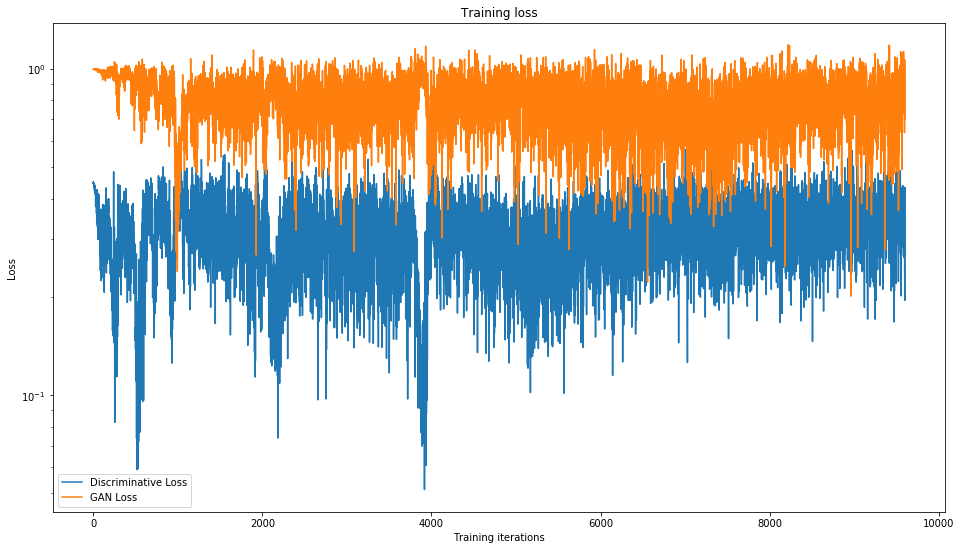

In [30]:
# Plot GAN losses
ax = pd.DataFrame(
    {
        'GAN Loss': gan_loss,
        'Discriminative Loss': discrimator_loss,
    }
).plot(title='Training loss', figsize=(16, 9), logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

In [31]:
# Run model against test set
predictions = gan.predict(X_test).squeeze()

In [32]:
# Get the prediction metrics of the model
print("The Mean Absolute Error: %.5f" % metrics.mean_absolute_error(y_test, predictions))  
print("The Median Absolute Error: %.5f" % metrics.median_absolute_error(y_test, predictions)) 
print("The Mean Squared Error: %.5f" % metrics.mean_squared_error(y_test, predictions)) 
print("The Root Mean Squared Error: %.5f" % (np.sqrt(metrics.mean_squared_error(y_test, predictions))))

The Mean Absolute Error: 0.10788
The Median Absolute Error: 0.08543
The Mean Squared Error: 0.01966
The Root Mean Squared Error: 0.14020


In [33]:
# Run Kolmogorov Smirnov test to verify the null hypothesis that the two samples (y_test and predictions) 
# are drawn from the same distribution
value, pValue = ks_2samp(y_test, predictions)

print("Kolmogorov Smirnov Test Statistic =", value, "  ", "pValue = ", pValue)

if pValue > 0.05:
	print('Samples are likely drawn from the same distributions (do not reject H0)')
else:
	print('Samples are likely drawn from different distributions (reject H0)')

Kolmogorov Smirnov Test Statistic = 0.5764705882352942    pValue =  1.1448033278402006e-25
Samples are likely drawn from different distributions (reject H0)


        Generated        Real
count  170.000000  170.000000
mean     0.062698    0.004384
std      0.014665    0.131545
min      0.008498   -0.326316
25%      0.065712   -0.053946
50%      0.069568    0.005438
75%      0.070131    0.059829
max      0.073302    0.338482


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9d5ab613c8>,
      dtype=object)

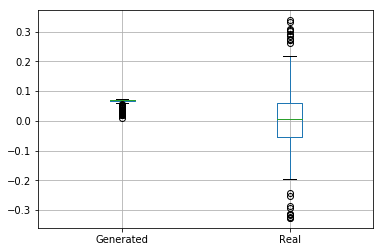

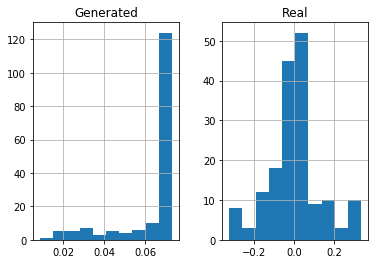

In [34]:
# Get statistics summary over real and generated data
results = pd.DataFrame({'Real':y_test, 'Generated': predictions})
print(results.describe())
results.boxplot()
results.hist(bins=10)

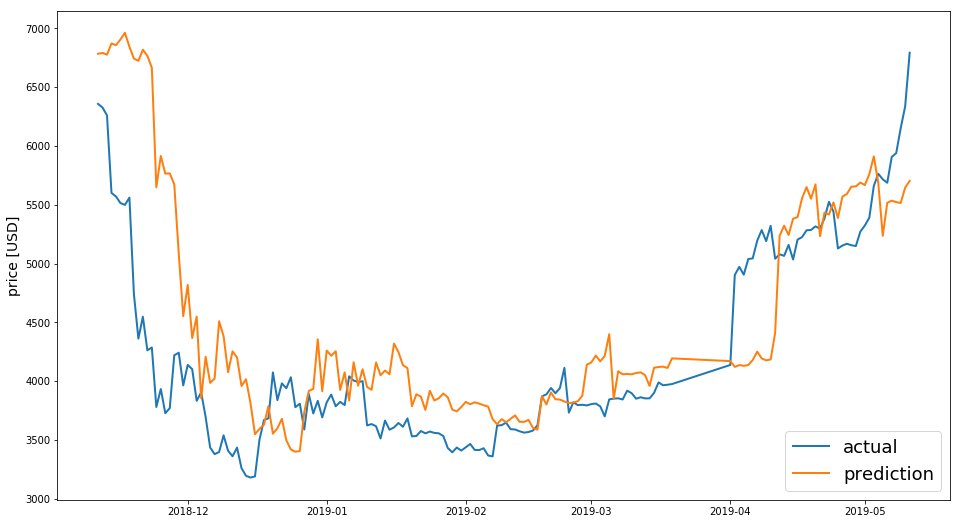

In [35]:
# Plot model predictions against actual data

# 1. Given that the final value is based on rate change, the prediction value is multiplied by the BTC price,
# which is the value previous to the defined TIME_STEPS, thus the future value is based on the formula:
# (CURR_VALUE from -TIME_STEPS days) * PREDICTED_VALUE_DENORMALIZED
# 2. Apply the same value used during the normalization for rate change calculation (df / df.iloc[0] - 1)
prediction_monetary_values = test.Close.values[:-TIME_STEPS] * (predictions + 1)
model_targets = test.Close[TIME_STEPS:]
prediction_series = pd.Series(index=model_targets.index, data=prediction_monetary_values)

line_plot(model_targets, prediction_series, 'actual', 'prediction')

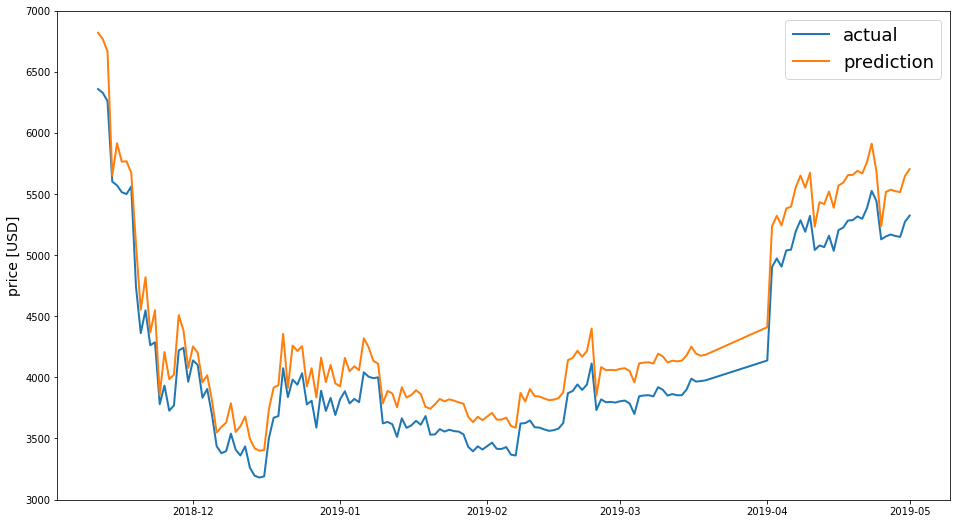

In [36]:
# Apply shift to get graphs aligned
line_plot(model_targets[:][:-TIME_STEPS], prediction_series.shift(-TIME_STEPS), 'actual', 'prediction')

In [64]:
# Save model

In [65]:
# Serialize model to JSON
model_json = gan.to_json()
with open("Model_Files/gan_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
gan.save_weights("Model_Files/gan_model.h5")
print("Saved model to disk")

Saved model to disk
